#### Tensorboard

Tensorboard is a visualization kit built by TensorFlow. It basically creates a nice informational dashboard to track and visualize metrics such as loss and accuracy, display images, text and audio data, profiling, projecting embeddings to lower dimensional spaces etc.

We are going to use Tensorboard on our FFN that we used for the MNIST multiclass classification task.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Import tensorboard SummaryWriter
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Define hyperparameters
input_size = 784 # Images are 28x28 = 784 pixels each
hidden_size = 100 # Number of neurons in the hidden layer
num_classes = 10 # 10 classes or digits to be predicted
num_epochs = 2 # 2 epochs
batch_size = 100 # 100 samples per batch
alpha = 1e-3 # Learning rate = 0.001

In [4]:
# Load datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Create tensorboard SummaryWriter
writer = SummaryWriter("runs/mnist")

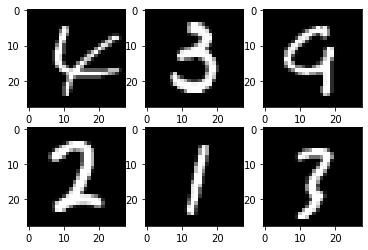

In [6]:
# Check sample
sample = iter(train_dataloader).next() # Next batch of 100 samples

# Display the first few samples in images
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample[0][i][0], cmap='gray')
# plt.show()

# Write this to the Tensorboard
img_grid = torchvision.utils.make_grid(sample[0])
writer.add_image('mnist_images', img_grid)
# writer.close()

In [7]:
# Create FFN
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        return (self.l2(self.relu(self.l1(x))))
        # We are not using any softmax layer or one-hot encoding the output since we are going to be using CrossEntropyLoss

In [8]:
# Define model
model = FFN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# Define criterion
criterion = nn.CrossEntropyLoss() # This is a multiclass classification problem

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=alpha) # The Adam optimizer will be used here

In [9]:
# Write model graph to tensorboard
writer.add_graph(model, sample[0].reshape(-1, 28*28))
# writer.close()

In [10]:
model = model.to(device) # The model has to be pushed to the device as well

In [11]:
# Training loop
num_iters = len(train_dataloader)

# Stats for Tensorboard
running_loss = 0.0
running_correct = 0.0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # images are of the shape 100, 1, 28, 28
        # There are 100 images per batch
        # Each image has 1 channel (grayscale) and 28x28 pixels
        # The required format is 100, 784
        # 100 samples each with 784 features (pixel values)
        images = images.view(images.shape[0], 28*28).to(device) # Reshape the tensor and push it to device
        labels = labels.to(device) # Also push labels to device
        
        # Forward propagation
        predicted_output = model(images)
        
        # Also add the number of correctly predicted samples to the running number of correctly predicted samples
        _, predictions = torch.max(predicted_output, 1)
        running_correct += (predictions == labels).sum().item()
        
        # Loss
        loss = criterion(predicted_output, labels)
        
        # Also add the loss to the running loss
        running_loss += loss.item()
        
        # Backprop
        loss.backward()
        
        # Parameter update
        optimizer.step()
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Print some information
        if (i+1) % 100 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, step: {i+1}/{num_iters}, loss: {loss.item():.3f}")
            
            # Also add training loss to the Tensorboard
            writer.add_scalar("Training loss", running_loss / 100, epoch * num_iters + i)
            
            # Also add training accuracy to the Tensorboard
            writer.add_scalar("Training accuracy", running_correct / 100, epoch * num_iters + i)
            
            # Zero out the running loss and accuracy for every batch
            running_loss = 0.0
            running_correct = 0.0

Epoch: 1/2, step: 100/600, loss: 0.415
Epoch: 1/2, step: 200/600, loss: 0.342
Epoch: 1/2, step: 300/600, loss: 0.379
Epoch: 1/2, step: 400/600, loss: 0.279
Epoch: 1/2, step: 500/600, loss: 0.292
Epoch: 1/2, step: 600/600, loss: 0.199
Epoch: 2/2, step: 100/600, loss: 0.182
Epoch: 2/2, step: 200/600, loss: 0.213
Epoch: 2/2, step: 300/600, loss: 0.184
Epoch: 2/2, step: 400/600, loss: 0.189
Epoch: 2/2, step: 500/600, loss: 0.133
Epoch: 2/2, step: 600/600, loss: 0.166


It is also possible to add multiple plots to the same graph by changing the running log directory in the definition of the SummaryWriter.

In [13]:
# Close the writer at the end of everything
writer.close()

It is also possible to do ROC curves and so on and so forth as per the requirement of the task and analysis of the model.